## Load texture examples from dataset

In [1]:
import bitis as bt

# Load the dataset
df = bt.datasets.tissue_dataset()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tissue Matrix          56 non-null     object 
 1   Density                56 non-null     float64
 2   Elongation             56 non-null     float64
 3   Orientation            56 non-null     float64
 4   Compactness            56 non-null     float64
 5   Structural_anisotropy  56 non-null     float64
 6   Complexity             56 non-null     float64
 7   Tissue size            56 non-null     object 
dtypes: float64(6), object(2)
memory usage: 3.6+ KB


## Select texture with given properties

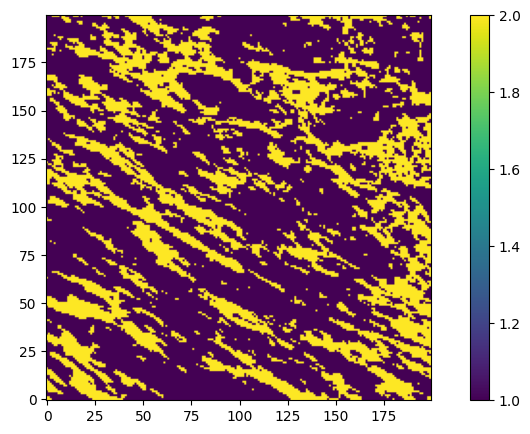

In [2]:
import bitis as bt
import numpy as np
import matplotlib.pyplot as plt


# Filter the dataset to extract one specific texture that meets the criteria:
filtered_df = df[(df['Density'].between(0.3, 0.35)) &
                 (df['Elongation'] > 2.5)]

# Select the first texture that meets the criteria
texture = filtered_df["Tissue Matrix"].iloc[0]

# Convert the texture to a matrix with values 1 and 2 and float32 type
training_tex = np.where(texture == 0, 1, 2).astype(np.float32)

plt.figure(figsize=(10, 5))
plt.imshow(training_tex, cmap='viridis', origin='lower')
plt.colorbar()
plt.show()


## Run simulation with adaptive window size

1. The random sequence of pixels coordinates is generated.
2. Each interation starts from building the template with the size of
`max_template_size` and reduces the size if number of known pixels is more than `max_known_pixels`. The reducing proceeds until `min_template_size` or `min_template_size` is reached.
3. The distance map between template and training image is calculated.
4. Best matching pixel value is randomly selected from closest `num_of_candidates` pixels on training image.
5. The selected candidate is added to the simulation texture.
6. The process is repeated for all pixels in the simulation sequence.

100%|██████████| 40000/40000 [00:11<00:00, 3503.38it/s]


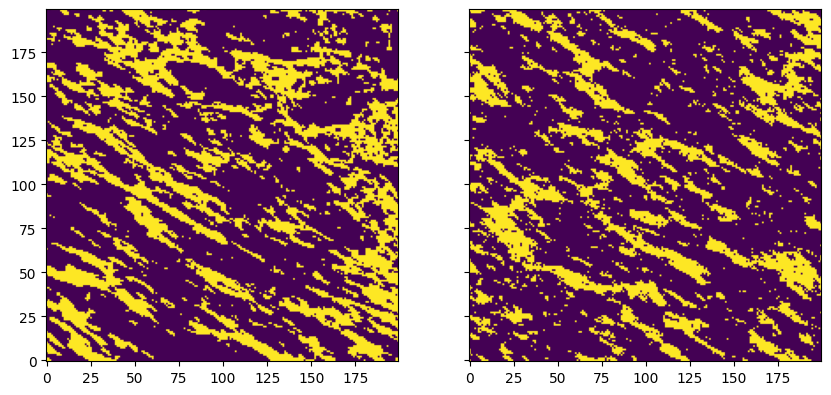

In [3]:
max_known_pixels = 30  # maximum number of known pixels in the template
max_template_size = 40  # largest possible template size
min_template_size = 3  # smallest possible template size
num_of_candidates = 3  # number of candidates from which the best one is selected
min_known_pixels = 1  # minimum number of known pixels in the template to build the template

# Initialize the simulation
simulation_tex = np.zeros_like(training_tex)
simulation = bt.AdaptiveSampling(simulation_tex,
                                    training_tex,
                                    max_known_pixels=max_known_pixels,
                                    min_known_pixels=min_known_pixels,
                                    max_template_size=max_template_size,
                                    min_template_size=min_template_size,
                                    n_candidates=num_of_candidates)

simulated_tex = simulation.run()

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].imshow(training_tex, origin='lower')
ax[1].imshow(simulated_tex, origin='lower')
plt.show()

## Multivariate simulation

The multivariate simulation is based on the idea that the texture is a joint distribution of multiple variables.

The distance map between template and training image is calculated as a weighted sum of distance maps between template and training image and the distance between joint training and simulated images.


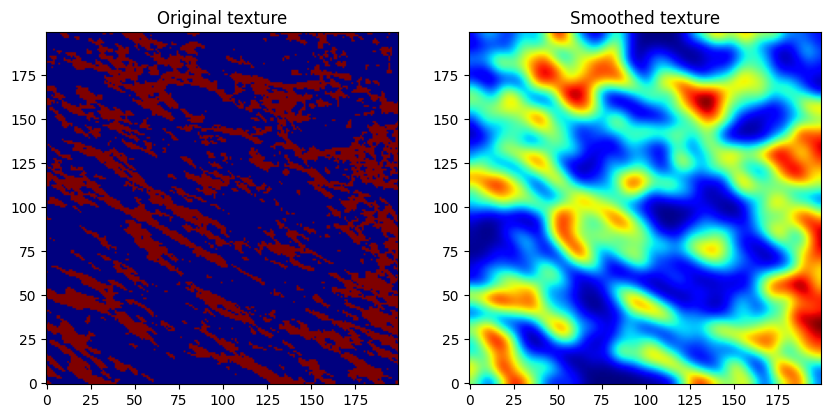

In [16]:
from scipy.ndimage import gaussian_filter


# Generate smoothed texture to use it as a joint training image
texture_smoothed = gaussian_filter(texture, sigma=5)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(texture, cmap='jet', origin='lower')
axs[0].set_title('Original texture')
axs[1].imshow(texture_smoothed, cmap='jet', origin='lower')
axs[1].set_title('Smoothed texture')
plt.show()

Use `ContinuousVariableMatching` to generate joint simulation image.

Generally, the joint simulation image can be generated or provided by the user.

100%|██████████| 40000/40000 [00:14<00:00, 2783.44it/s]


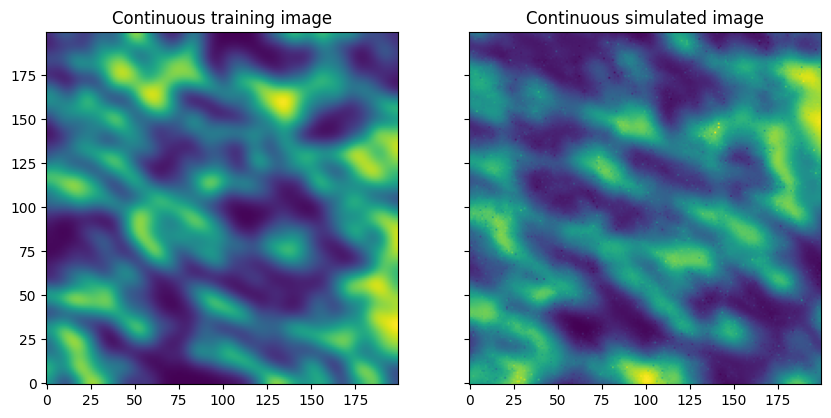

In [18]:
# Use 'ContinuousVariableMatching' to generate joint simulation image.
# Generally, the joint simulation image can be generated or provided by the user.
max_known_pixels = 30
max_template_size = 40
min_template_size = 3
num_of_candidates = 2
min_known_pixels = 1

training_image = texture_smoothed

simulation_tex = np.zeros_like(training_image)
simulation = bt.Simulation()
simulation.path_builder = bt.RandomSimulationPathBuilder(simulation_tex)
simulation.template_builder = bt.AdaptiveTemplateBuilder(simulation_tex,
                                                         max_known_pixels,
                                                         max_template_size,
                                                         min_template_size)
simulation.template_matching = bt.ContinuousVariableMatching(training_image,
                                                             num_of_candidates,
                                                             min_known_pixels)
simulated_tex = simulation.run()

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].imshow(training_image, origin='lower')
ax[0].set_title('Continuous training image')
ax[1].imshow(simulated_tex, origin='lower')
ax[1].set_title('Continuous simulated image')
plt.show()

joint_training_image = training_image.copy()
joint_simulated_image = simulated_tex.copy()

Multivariate simulation provides the tool to control the distribution of specific texture features.

100%|██████████| 40000/40000 [00:11<00:00, 3360.71it/s]


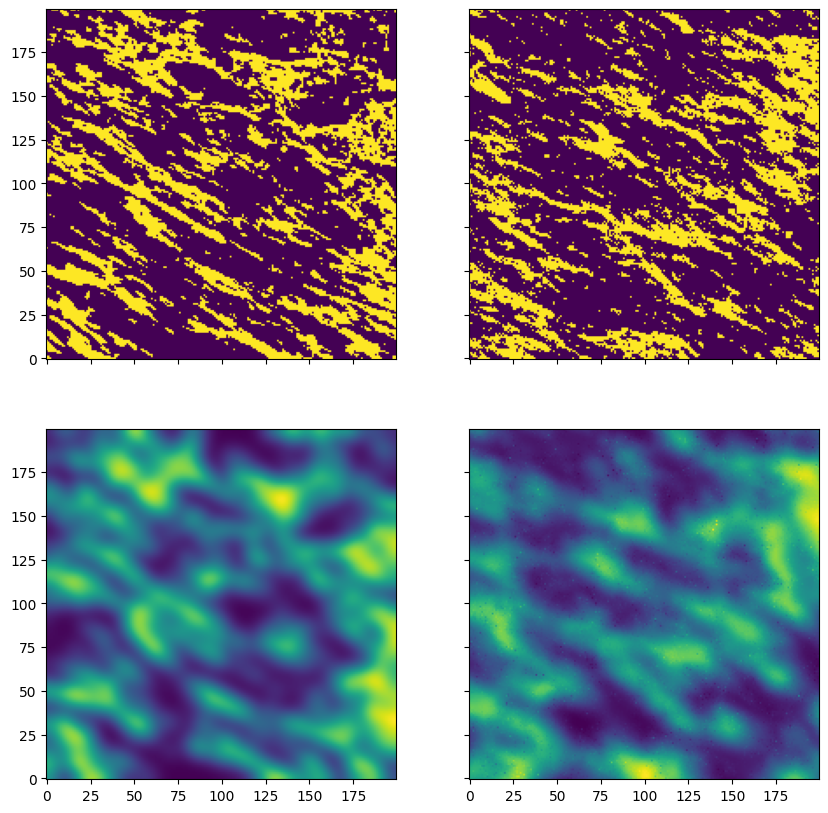

In [20]:
training_image = texture.copy()

max_known_pixels = 30
max_template_size = 40
min_template_size = 3
n_candidates = 3
min_known_pixels = 1

simulation_tex = np.zeros_like(training_image)
multi_var_simulation = bt.Simulation()
multi_var_simulation.path_builder = bt.MultivariateSimulationPathBuilder(simulation_tex)
multi_var_simulation.template_builder = bt.AdaptiveTemplateBuilder(simulation_tex,
                                                                   max_known_pixels,
                                                                   max_template_size,
                                                                   min_template_size)
multi_var_simulation.template_matching = bt.MultivariateVariableMatching(training_image,
                                                                         joint_training_image,
                                                                         joint_simulated_image,
                                                                         n_candidates,
                                                                         min_known_pixels)

simulated_tex = multi_var_simulation.run()

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax[0, 0].imshow(training_image, origin='lower')
ax[0, 1].imshow(simulated_tex, origin='lower')
ax[1, 0].imshow(joint_training_image, origin='lower')
ax[1, 1].imshow(joint_simulated_image, origin='lower')
plt.show()